In [6]:
import pandas as pd
import chess
import chess.pgn
import io
import seaborn as sns
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

# from IPython.display import SVG
# from sknetwork.embedding import LouvainEmbedding
# from sknetwork.clustering import Louvain
# from sknetwork.data import from_edge_list, from_adjacency_list, from_graphml, from_csv
# from sknetwork.visualization import svg_graph, svg_bigraph
import networkx as nx
import networkx.algorithms.community as nx_comm


Lien pour accéder à la donnée : https://database.nikonoel.fr/lichess_elite_2020-06.zip

## 1. Import et affichage

In [7]:
df = pd.DataFrame(columns=['Opening', 'Result', 'WhiteId', 'BlackId', 'WhiteElo', 'BlackElo'])
games = open('lichess_elite_2020-06.pgn')
for k in range(20000) :
   game = chess.pgn.read_game(games)
   df.loc[len(df.index)] = [game.headers['Opening'],  
                            game.headers['Result'], 
                            game.headers['White'], 
                            game.headers['Black'],
                            game.headers['WhiteElo'], 
                            game.headers['BlackElo']]


mapping = {'1-0' : 1, '1/2-1/2' :0, '0-1' : -1}
df.Result = df.Result.map(mapping)

In [8]:
df = df[df.Opening != '?'] # On supprime les openings non-référencés dans nos 20k parties.
df.Opening = df.Opening.apply(lambda x: x.split(':')[0])

In [9]:
df.head()

,Opening,Result,WhiteId,BlackId,WhiteElo,BlackElo
0,French Defense,0.0,Cor64,matapalo,2413,2254
1,Sicilian Defense,1.0,Poecraft94,Germanvince,2323,2415
2,Modern Defense,0.0,sandstorm00,yendorzerep,2497,2426
3,Queen's Gambit Declined,-1.0,DanielaAndrade,Dapsay,2387,2416
4,Dutch Defense,1.0,SuperRuddy,gmbalaargentino,2288,2469


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Result', ylabel='count'>

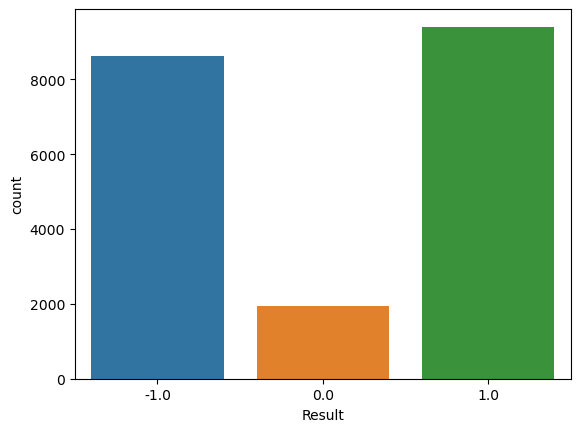

In [10]:
sns.countplot(df.Result)

Il y a assez peu de nulles, ce qui n'est pas choquant à haut niveau.

## 2. Ouvertures

In [11]:
df_opening = pd.DataFrame(df.groupby(by = ['Opening', 'Result']).count()['WhiteId']).unstack(level = -1)['WhiteId']

In [12]:
df_opening = df_opening.fillna(0)

In [13]:
df_opening['Nb_games'] = df_opening[-1] + df_opening[0] + df_opening[1]

In [14]:
df_opening[-1] = (df_opening[-1]/df_opening.Nb_games)*100
df_opening[0] = (df_opening[0]/df_opening.Nb_games)*100
df_opening[1] = (df_opening[1]/df_opening.Nb_games)*100

In [15]:
df_opening

Result,-1.0,0.0,1.0,Nb_games
Opening,,,,
Alekhine Defense,43.666667,8.333333,48.000000,300.0
Amar Opening,0.000000,0.000000,100.000000,2.0
Anderssen Opening,34.615385,3.846154,61.538462,26.0
Australian Defense,50.000000,0.000000,50.000000,4.0
Barnes Defense,50.000000,0.000000,50.000000,2.0
...,...,...,...,...
Wade Defense,31.578947,26.315789,42.105263,19.0
Ware Defense,0.000000,50.000000,50.000000,2.0
Ware Opening,50.000000,0.000000,50.000000,2.0


In [16]:
df_opening = df_opening[df_opening.Nb_games > 5]

In [17]:
df_opening.iloc[np.argmax(df_opening[1]), :]

Result
-1.0        28.571429
0.0          0.000000
1.0         71.428571
Nb_games     7.000000
Name: Benko Gambit Accepted, Dlugy Variation, dtype: float64

In [18]:
df_opening.iloc[np.argmax(df_opening[-1]), :]

Result
-1.0        84.615385
0.0          0.000000
1.0         15.384615
Nb_games    13.000000
Name: King's Gambit Declined, Classical Variation, dtype: float64

## 3. Analyse du Elo

In [19]:
df_elo = df[['Result', 'WhiteElo', 'BlackElo']]

In [20]:
df_elo = df_elo[df_elo.Result != 0]

In [21]:
df_elo_grouped = pd.DataFrame(df_elo.groupby(['WhiteElo', 'Result']).count().BlackElo)

In [22]:
df_elo_grouped = df_elo_grouped.unstack(level = -1)['BlackElo']

In [23]:
df_elo_grouped = df_elo_grouped.fillna(0)

In [24]:
df_elo_grouped

Result,-1.0,1.0
WhiteElo,,
2200,8.0,3.0
2201,8.0,1.0
2202,4.0,2.0
2203,6.0,2.0
2204,5.0,1.0
...,...,...
2887,0.0,1.0
2888,1.0,2.0
2891,0.0,1.0


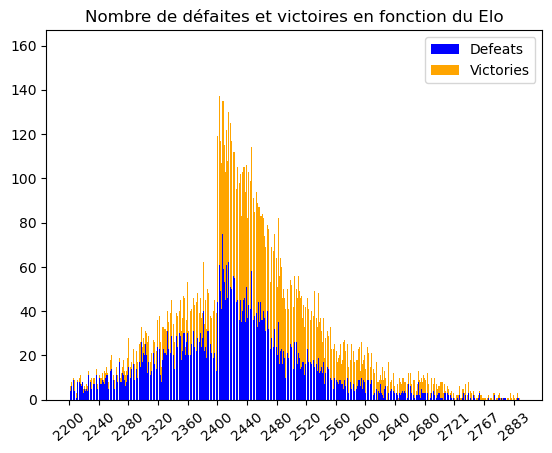

In [25]:
x_labels = np.linspace(int(df_elo_grouped.index.min()), int(df_elo_grouped.index.max()), num =30)

plt.bar(df_elo_grouped.index, df_elo_grouped[-1], color='b', label = 'Defeats')
plt.bar(df_elo_grouped.index, df_elo_grouped[1], bottom = df_elo_grouped[-1], color='orange', label = 'Victories')
plt.xticks(range(len(df_elo_grouped))[::40], df_elo_grouped.index[::40], rotation = 40)

plt.title('Nombre de défaites et victoires en fonction du Elo')
plt.legend()
plt.show()

## 4. Analyse des joueurs

In [26]:
players = pd.Series(pd.Series(np.concatenate((df.WhiteId.unique(),df.BlackId.unique()))).unique())

In [27]:
df_players = pd.DataFrame(columns = ['Player', 'Elo_max', 'Nb_parties', 'Ouverture_Favorite', 'Ouverture_wins', 'Ouverture_loses'])

df_players['Player'] = players

df_players['Elo_max'] = players.apply(lambda x : max(int(df[(df.WhiteId == x) | (df.BlackId == x)].WhiteElo.max()),int(df[(df.WhiteId == x) | (df.BlackId == x)].BlackElo.max())))

df_players['Nb_parties'] = players.apply(lambda x : (df.BlackId.value_counts()[x] if x in df.BlackId.value_counts() else 0) + (df.WhiteId.value_counts()[x] if x in df.WhiteId.value_counts() else 0))

df_players['Ouverture_Favorite'] = players.apply(lambda x :pd.concat((df[df.WhiteId == x].Opening, df[df.BlackId == x].Opening)).value_counts().index[0])

def find_wins(x):
    if len(pd.concat((df[(df.WhiteId == x) & (df.Result == 1)].Opening, df[(df.BlackId == x) & (df.Result == -1)].Opening)).value_counts().index) != 0:
        return pd.concat((df[(df.WhiteId == x) & (df.Result == 1)].Opening, df[(df.BlackId == x) & (df.Result == -1)].Opening)).value_counts().index[0]
    else:
        return None
    
def find_defeats(x):
    if len(pd.concat((df[(df.WhiteId == x) & (df.Result == -1)].Opening, df[(df.BlackId == x) & (df.Result == 1)].Opening)).value_counts().index) != 0:
        return pd.concat((df[(df.WhiteId == x) & (df.Result == -1)].Opening, df[(df.BlackId == x) & (df.Result == 1)].Opening)).value_counts().index[0]
    else:
        return None

df_players['Ouverture_wins'] = players.apply(find_wins)
df_players['Ouverture_loses'] = players.apply(find_defeats)



In [28]:
df_players

,Player,Elo_max,Nb_parties,Ouverture_Favorite,Ouverture_wins,Ouverture_loses
0,Cor64,2578,154,Sicilian Defense,Sicilian Defense,Sicilian Defense
1,Poecraft94,2415,2,Sicilian Defense,Sicilian Defense,Sicilian Defense
2,sandstorm00,2599,13,Modern Defense,Sicilian Defense,Nimzo-Indian Defense
3,DanielaAndrade,2456,13,Nimzo-Indian Defense,Nimzo-Indian Defense,Queen's Gambit Declined
4,SuperRuddy,2585,9,Dutch Defense,Dutch Defense,Indian Game
...,...,...,...,...,...,...
5128,SamanArmand,2446,1,Neo-Grünfeld Defense,None,Neo-Grünfeld Defense
5129,HelgiGretarsson,2548,1,Modern Defense,Modern Defense,None
5130,ehlabas,2429,1,Italian Game,None,Italian Game
5131,Bibekthing,2415,1,Sicilian Defense,None,Sicilian Defense


In [29]:
df_players.Ouverture_Favorite.value_counts()

Sicilian Defense                                            1347
English Opening                                              334
French Defense                                               334
Caro-Kann Defense                                            271
Queen's Pawn Game                                            200
                                                            ... 
King's Gambit Accepted, King's Knight Gambit                   1
Bronstein Gambit                                               1
Sodium Attack                                                  1
Canard Opening                                                 1
King's Gambit, Falkbeer Countergambit, Hinrichsen Gambit       1
Name: Ouverture_Favorite, Length: 131, dtype: int64

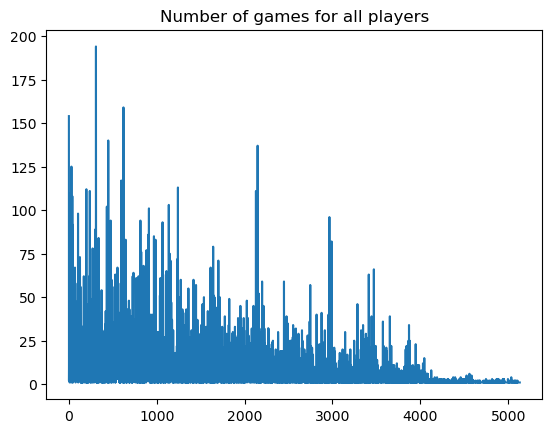

In [30]:
plt.title('Number of games for all players')
df_players.Nb_parties.plot()
plt.show()

## 5. Relations entre joueurs 

In [31]:
df_players = pd.DataFrame(columns=['Opening', 'Result'])
games = open('lichess_elite_2020-06.pgn')
dico_vs = {}
for k in range(250) :
   game = chess.pgn.read_game(games)
   black = game.headers['Black']
   white = game.headers['White']

   # création d'un dico des adversaires + nbr de parties jouées en parcourant les joueurs noirs
   if black not in dico_vs :
      dico_vs[black] = {white : 1}
   elif white not in dico_vs[black] :
      dico_vs[black][white] = 1
   elif white in dico_vs[black]:
      dico_vs[black][white] += 1

   # idem en parcourant les joueurs blancs (on aura les infos en double et une matrice d'adjacence symétrique mais on en a besoin pour tracer le graphe)
   if white not in dico_vs :
      dico_vs[white] = {black : 1}
   elif black not in dico_vs[white] :
      dico_vs[white][black] = 1
   elif black in dico_vs[white]:
      dico_vs[white][black] += 1


print(dico_vs)

{'matapalo': {'Cor64': 1}, 'Cor64': {'matapalo': 1, 'pabloin': 1, 'FrankVH': 2, 'elenmascarado': 1}, 'Germanvince': {'Poecraft94': 1}, 'Poecraft94': {'Germanvince': 1}, 'yendorzerep': {'sandstorm00': 1, 'Majasystem': 1}, 'sandstorm00': {'yendorzerep': 1, 'hblanco': 1}, 'Dapsay': {'DanielaAndrade': 3, 'lestri': 1}, 'DanielaAndrade': {'Dapsay': 3}, 'gmbalaargentino': {'SuperRuddy': 4}, 'SuperRuddy': {'gmbalaargentino': 4}, 'EnPassant81': {'Andnar': 2, 'fleetfeet': 2, 'Termenoil': 1}, 'Andnar': {'EnPassant81': 2, 'self_service': 2}, 'self_service': {'CamelClutcher': 1, 'Tsovnoog': 2, 'Andnar': 2}, 'CamelClutcher': {'self_service': 1}, 'No_Move_Left': {'LePersifleur': 2, 'nicola_cola': 1}, 'LePersifleur': {'No_Move_Left': 2}, 'Fasmc17': {'Mjolnir1980': 1}, 'Mjolnir1980': {'Fasmc17': 1}, 'Rechlis': {'FO_Junior': 1, 'AitorRO': 1, 'extremo2': 1, 'Alfilparanoico': 1, 'asticot95': 1, 'Plattfuss': 1, 'Powerrino': 1, 'Kiryukha': 1}, 'FO_Junior': {'Rechlis': 1}, 'akiskara': {'Odirovski': 2, 'merid

In [32]:
# création d'une matrice d'adjacence des joueurs : le coef (i,j) représente le nombre de parties entre i et j

def dict_to_adj(dico) :
    list_vs = list(dico)
    n = len(list_vs)
    adj = np.zeros([n,n])
    for player in dico.keys():
        for opponent in (dico[player]).keys() :
            adj[list_vs.index(player)][list_vs.index(opponent)] = dico_vs[player][opponent]

    return adj

adj = dict_to_adj(dico_vs)

In [33]:
# création du graphe avec NetworkX

G = nx.from_numpy_array(adj)



# récupération des poids du graphes

weights = []
edges = G.edges(data=True)
#print(edges)
for edge in edges :
     
     weights.append(edge[2]['weight'])

#algo de Louvain pour le clustering
communities = nx_comm.louvain_communities(G, resolution = 1)

#================

# créer un dictionnaire de couleurs pour chaque communauté

#================

# palette de couleurs pour les noeuds

palette1 = sns.color_palette('tab20b', len(communities))
palette2 = sns.color_palette('tab20c', 20-len(communities))

palette = palette1 + palette2
unique_palette = list(set(palette))

print(f"len(palette): {len(palette)}")
print(f"len(unique_palette): {len(unique_palette)}")



player2color_cluster = {} #dico pour lier les noeuds à une couleur
print(f"\nlen(communities): {len(communities)}")

# on prend la même couleur pour tous les noeuds d'une communauté (seulement si taille de la communauté > 5)
for community_no, community in enumerate(communities) :
    #print(len(community))
    # print(f"community: {community}")
    for node in community :
        
        if len(community)> 5 :
        # print(f"node: {node}")
            player2color_cluster[node] = palette[community_no]
        else :
            player2color_cluster[node] = (0,0,0)
#print(f"\nlen(player2color_cluster): {len(player2color_cluster)}")




# unique_list_colors = list(set(list_colors))
# print(f"\nlen(list_colors): {len(list_colors)}")
# print(f"\nlen(unique_list_colors): {len(unique_list_colors)}")



player2color_cluster = dict(sorted(player2color_cluster.items(), key = lambda item : item[0])) #trier sur les clés (id du joueur) utile dans la fonction draw_nodes
list_colors = list(player2color_cluster.values()) #transformation en liste







len(palette): 46
len(unique_palette): 20

len(communities): 46


In [34]:
degrees = []

for degree in G.degree:
    degrees.append(100*degree[1])

In [35]:
players = list(dico_vs.keys())
len(players)

204

(-1.197545999923038, 1.0789364753805422, -1.097263426964047, 1.113031627016323)

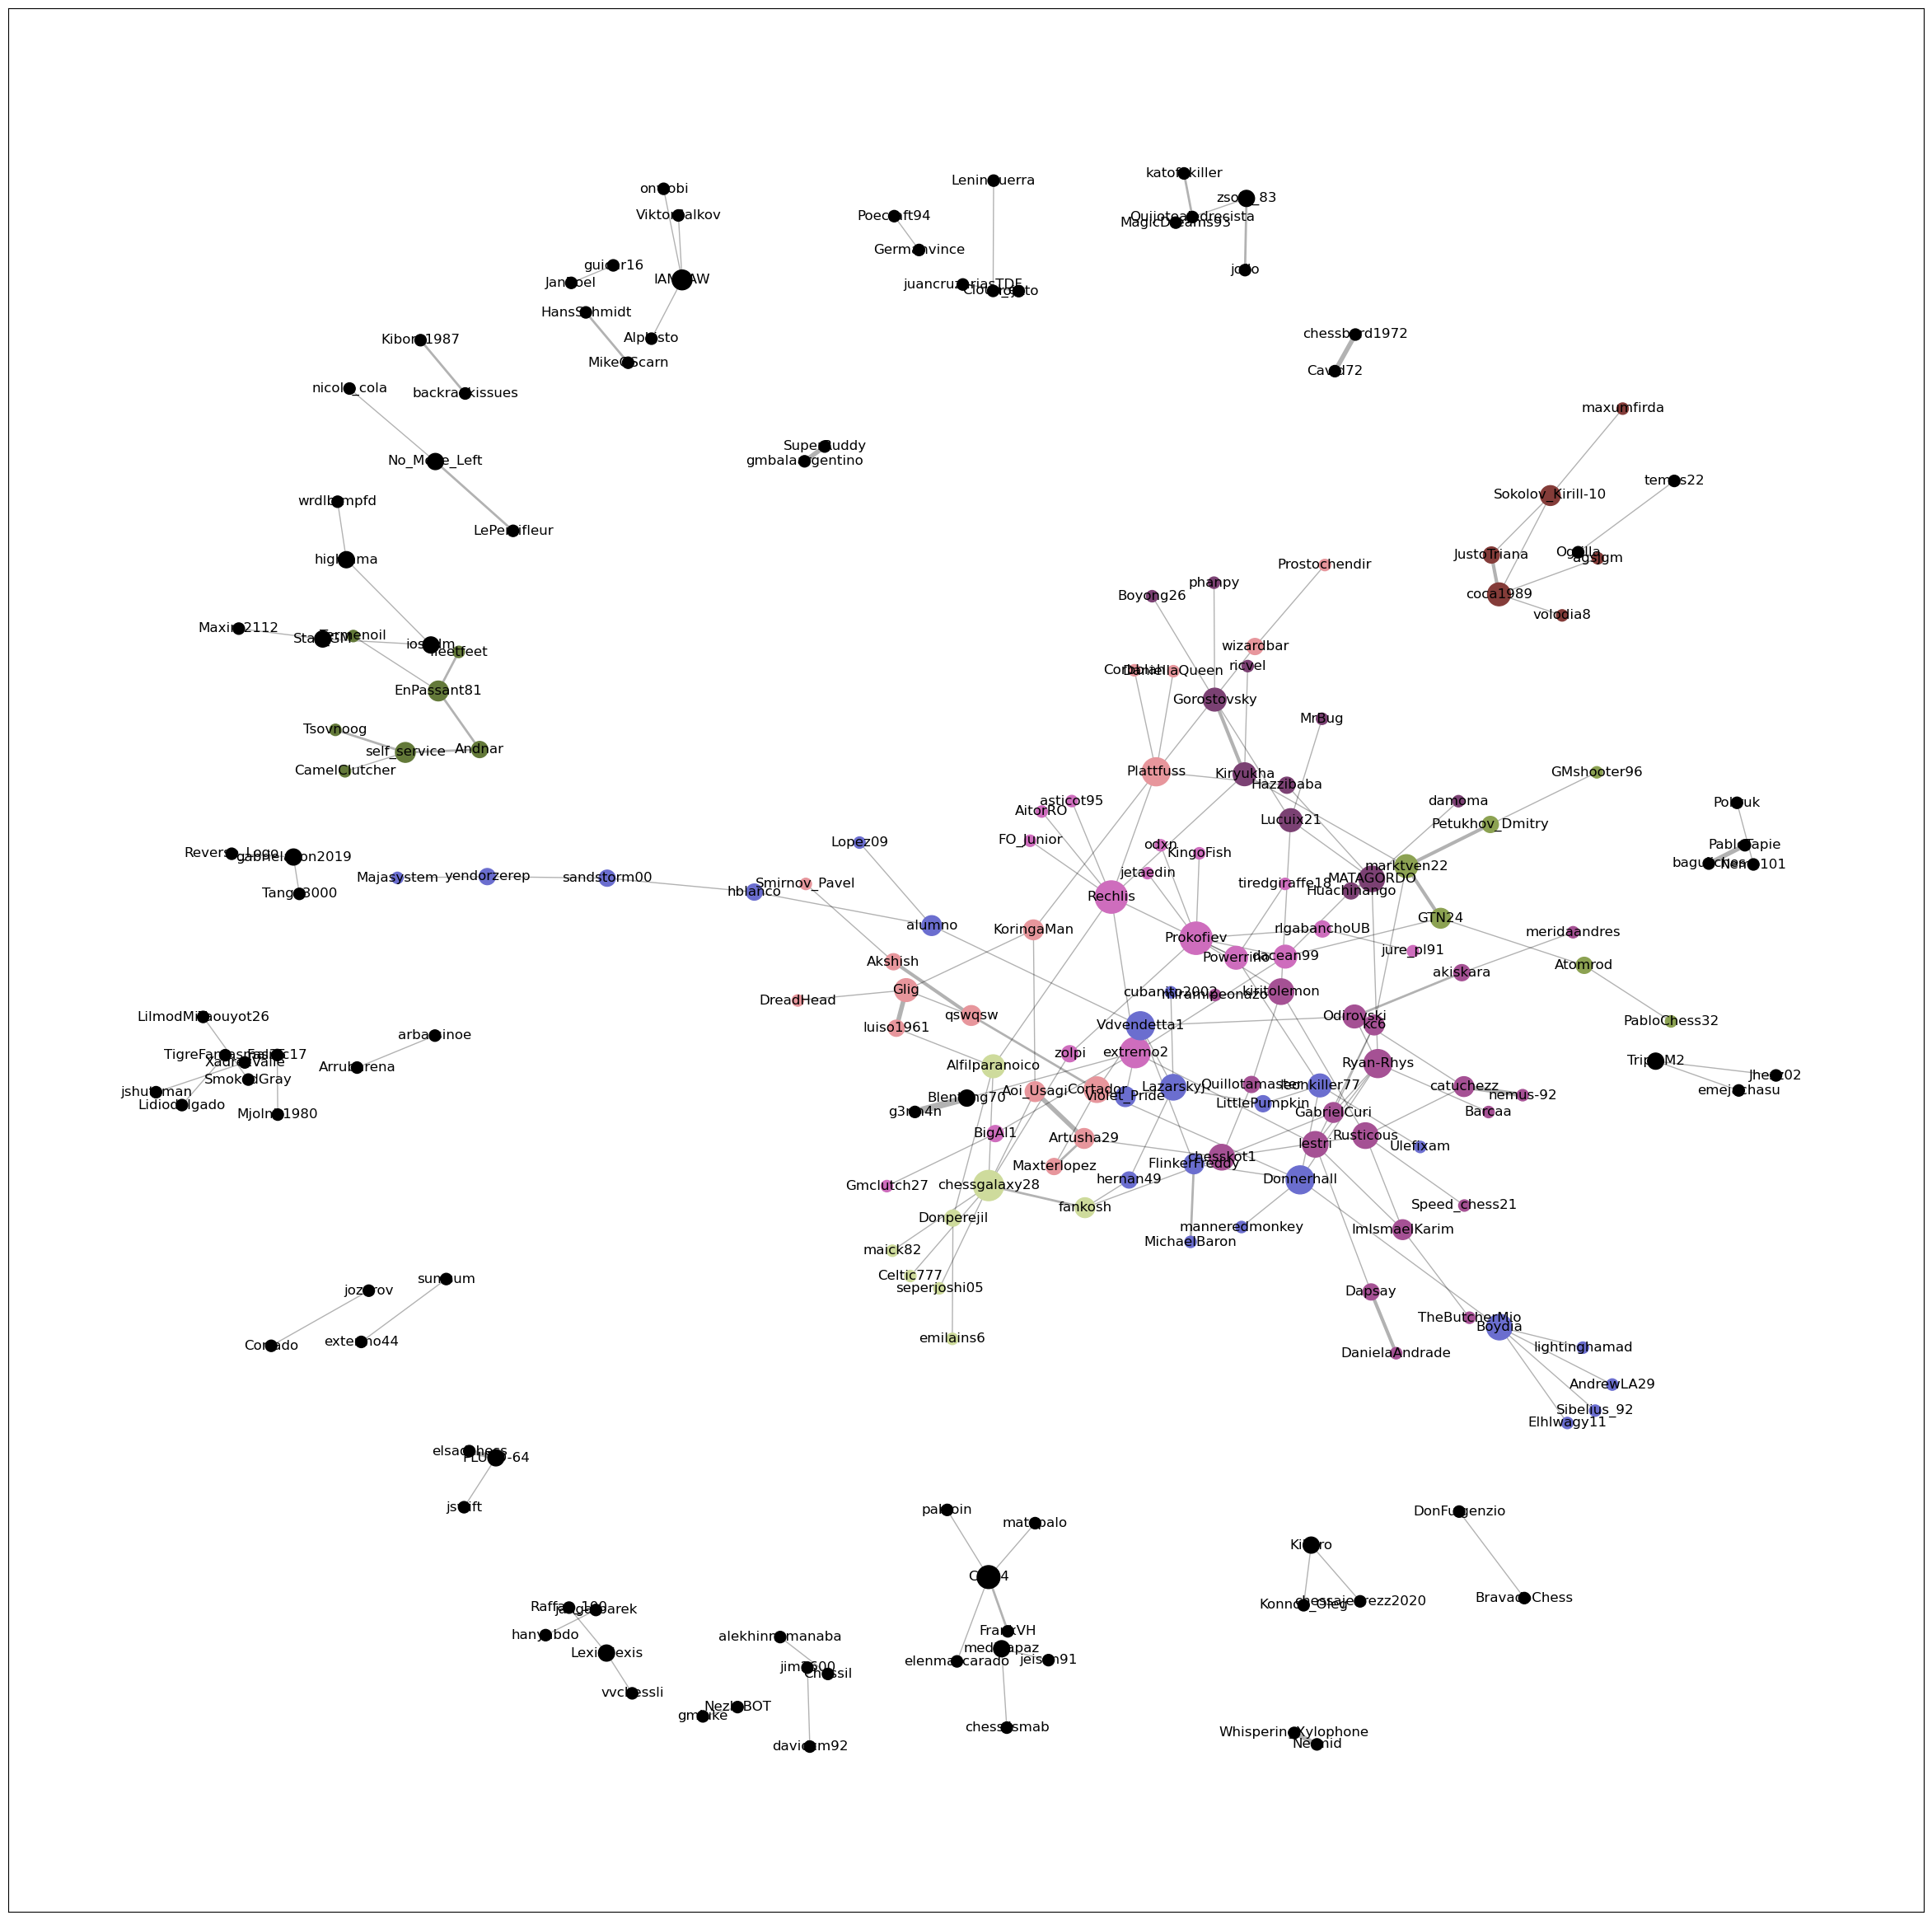

In [36]:
plt.figure(figsize=(30,30))

pos = nx.spring_layout(G, k = 1/7)

nx.draw_networkx_nodes(G, pos, node_color = list_colors, label = dico_vs.keys(), node_size = degrees)
nx.draw_networkx_edges(G, pos, width = weights, alpha = 0.3)
nx.draw_networkx_labels(G, pos=pos, labels= {n : players[n] for n in range(len(players))})


plt.axis('equal')

In [48]:
n = 300

games = open('lichess_elite_2020-06.pgn')


df_graphing = pd.DataFrame(columns = ['Black', 'White'], index = list(range(n)))
#df_graphing.index = list(range(400))
for k in range(n) :
    game = chess.pgn.read_game(games)
    df_graphing['Black'][k] = game.headers['Black']
    df_graphing['White'][k]= game.headers['White']
    #print(game.headers['Black'])

In [49]:
df_graphing

,Black,White
0,matapalo,Cor64
1,Germanvince,Poecraft94
2,yendorzerep,sandstorm00
3,Dapsay,DanielaAndrade
4,gmbalaargentino,SuperRuddy
...,...,...
295,Cortador,nastroyani
296,mohammedarrami,Blentong70
297,jshutzman,Alfilparanoico
298,Cavid72,chessbard1972


In [50]:
df_graphing = df_graphing.reset_index(drop = True)

In [52]:
df_graphing.to_csv('graph_data.csv', index=False)